# 라이브러리 호출

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import random

# resnet의 layer 선언

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # padding, keep the image size constant after next conv2d
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )
    
    def forward(self, x):
        return x + self.block(x)

# fake image를 만들어 내는 generateor

In [3]:
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        
        out_channels=64
        self.conv = nn.Sequential(
            nn.ReflectionPad2d(in_channels), 
            nn.Conv2d(in_channels, out_channels, 2*in_channels+1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        
        channels = out_channels
        
        self.down = []
        for _ in range(2):
            out_channels = channels * 2
            self.down += [
                nn.Conv2d(channels, out_channels, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.down = nn.Sequential(*self.down)
        
        self.trans = [ResidualBlock(channels) for _ in range(num_residual_blocks)]
        self.trans = nn.Sequential(*self.trans)
        self.up = []
        
        for _ in range(2):
            out_channels = channels // 2
            self.up += [
                nn.Upsample(scale_factor=2), # bilinear interpolation
                nn.Conv2d(channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),
            ]
            channels = out_channels
        self.up = nn.Sequential(*self.up)
        
        self.out = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(channels, in_channels, 2*in_channels+1),
            nn.Tanh()
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = self.down(x)
        x = self.trans(x)
        x = self.up(x)
        x = self.out(x)
        return x

# 진짜 image인지 가짜 image인지 구분 

In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            *self.block(in_channels, 64, normalize=False),
            *self.block(64, 128),  
            *self.block(128, 256), 
            *self.block(256, 512),
            
            nn.ZeroPad2d((1,0,1,0)), 
            nn.Conv2d(512, 1, 4, padding=1)
        )
        
        self.scale_factor = 16
    
    @staticmethod
    def block(in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return layers
        
    def forward(self, x):
        return self.model(x)

# loss funtion 선언

In [5]:
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# model 선언

In [6]:
G_AB = GeneratorResNet(3, num_residual_blocks=9)
D_B = Discriminator(3)

G_BA = GeneratorResNet(3, num_residual_blocks=9)
D_A = Discriminator(3)

In [7]:
cuda = torch.cuda.is_available()
print(f'cuda: {cuda}')
if cuda:
    G_AB = G_AB.cuda()
    D_B = D_B.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    
    criterion_GAN = criterion_GAN.cuda()
    criterion_cycle = criterion_cycle.cuda()
    criterion_identity = criterion_identity.cuda()

cuda: True


# optimizer 선언

In [8]:
import itertools
lr = 1e-5


optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr
)

optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr
)

In [9]:
n_epoches = 300
decay_epoch = 20

lambda_func = lambda epoch: 1 - max(0, epoch-decay_epoch)/(n_epoches-decay_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_func)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lambda_func)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lambda_func)

# dataset 호출 함수

In [10]:
class Dataset(object):
    def __init__(self, label_dir, input_dir, image_size, scale):
        self.label_dir = [os.path.join(label_dir, x) for x in os.listdir(label_dir) if self.check_image_file(x)]
        self.input_dir = [os.path.join(input_dir, x) for x in os.listdir(input_dir) if self.check_image_file(x)]
        self.image_size = image_size
        self.to_Tensor = transforms.ToTensor()
        self.resize = transforms.Resize((128 , 128 ), interpolation=Image.BICUBIC)
        self.rotates = [0, 90, 180, 270]
        self.nomalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    
    def check_image_file(self, filename: str):
        return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".JPG", ".JPEG", ".PNG", ".BMP"])
    
    def data_augmentation(self, hr, lr):

        width, height = hr.size

        #x = random.randint(0, width - self.image_size)
        #y = random.randint(0, height - self.image_size)
     

        
        #hr = hr.crop((x, y, x+self.image_size, y+self.image_size))
        #lr = lr.crop((x, y, x+self.image_size, y+self.image_size))
        
        hr = hr.resize((320, 180), resample=Image.BICUBIC)
        lr = lr.resize((320, 180), resample=Image.BICUBIC)
        ''''''
    
        return hr, lr

    def __getitem__(self, idx):
    
    
        hr = Image.open(self.label_dir[idx]).convert("RGB")
        lr = Image.open(self.input_dir[idx]).convert("RGB") 

        hr, lr = self.data_augmentation(hr, lr) 
        
        return self.to_Tensor(hr), self.to_Tensor(lr) # 데이터 셋 반환

    def __len__(self):
        return len(self.label_dir)

In [11]:
class TestDataset(object):
    def __init__(self, label_dir, input_dir, image_size, scale):
        self.label_dir = [os.path.join(label_dir, x) for x in os.listdir(label_dir) if self.check_image_file(x)]
        self.input_dir = [os.path.join(input_dir, x) for x in os.listdir(input_dir) if self.check_image_file(x)]
        self.image_size = image_size
        self.to_Tensor = transforms.ToTensor()
        self.resize = transforms.Resize((image_size , image_size ), interpolation=Image.BICUBIC)
        self.rotates = [0, 90, 180, 270]
     
    
    def check_image_file(self, filename: str):
        return any(filename.endswith(extension) for extension in [".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".JPG", ".JPEG", ".PNG", ".BMP"])
    

    def data_augmentation(self, hr, lr):

        width, height = hr.size

        hr = hr.resize((320, 180), resample=Image.BICUBIC)
        lr = lr.resize((320, 180), resample=Image.BICUBIC)
        '''
            '''
        return hr, lr

    def __getitem__(self, idx):

        hr = Image.open(self.label_dir[idx]).convert("RGB") 
        lr = Image.open(self.input_dir[idx]).convert("RGB") 

 
        hr, lr = self.data_augmentation(hr, lr) 
        return self.to_Tensor(hr), self.to_Tensor(lr) 

    def __len__(self):
        return len(self.label_dir)

In [12]:
train_dir = '/data/chgo/trainA'
label_dir = '/data/chgo/trainB'

In [13]:
test_dir = '/data/chgo/낮'
test_label_dir = '/data/chgo/밤'

In [14]:
train_dataset = Dataset(train_dir , label_dir,256,1)

In [15]:
test_dataset = TestDataset(train_dir ,label_dir,256,1)

In [16]:
len(train_dataset)

24000

In [17]:
transforms_ = transforms.Compose([
   # transforms.Resize(int(256*1.12), Image.BICUBIC),
    #transforms.RandomCrop(256, 256),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [18]:
train_loader = DataLoader(
    train_dataset,
    batch_size = 4,
    shuffle = True,
    num_workers = 4
)



In [19]:
test_loader = DataLoader(
    test_dataset,
    batch_size = 2,
    shuffle = True
)

In [20]:
len(train_loader)

6000

# real image와 fake image를 시각화

In [21]:
from torchvision.utils import make_grid
import random
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

def sample_images(real_A, real_B, figside=1.5):
    assert real_A.size() == real_B.size(), 'The image size for two domains must be the same'
    
    G_AB.eval()
    G_BA.eval()
    
    real_A = real_A.type(Tensor)
    fake_B = G_AB(real_A).detach()

    real_B = real_B.type(Tensor)
    fake_A = G_BA(real_B).detach()

    
    nrows = real_A.size(0)
    real_A = make_grid(real_A, nrow=nrows, normalize=True)
    fake_B = make_grid(fake_B, nrow=nrows, normalize=True)
    real_B = make_grid(real_B, nrow=nrows, normalize=True)
    fake_A = make_grid(fake_A, nrow=nrows, normalize=True)
    
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1).cpu().permute(1, 2, 0)
    
    plt.figure(figsize=(30, 15))
    plt.imshow(image_grid)
    plt.axis('off')
    plt.show()
    

torch.Size([4, 3, 180, 320])
torch.Size([4, 3, 180, 320])


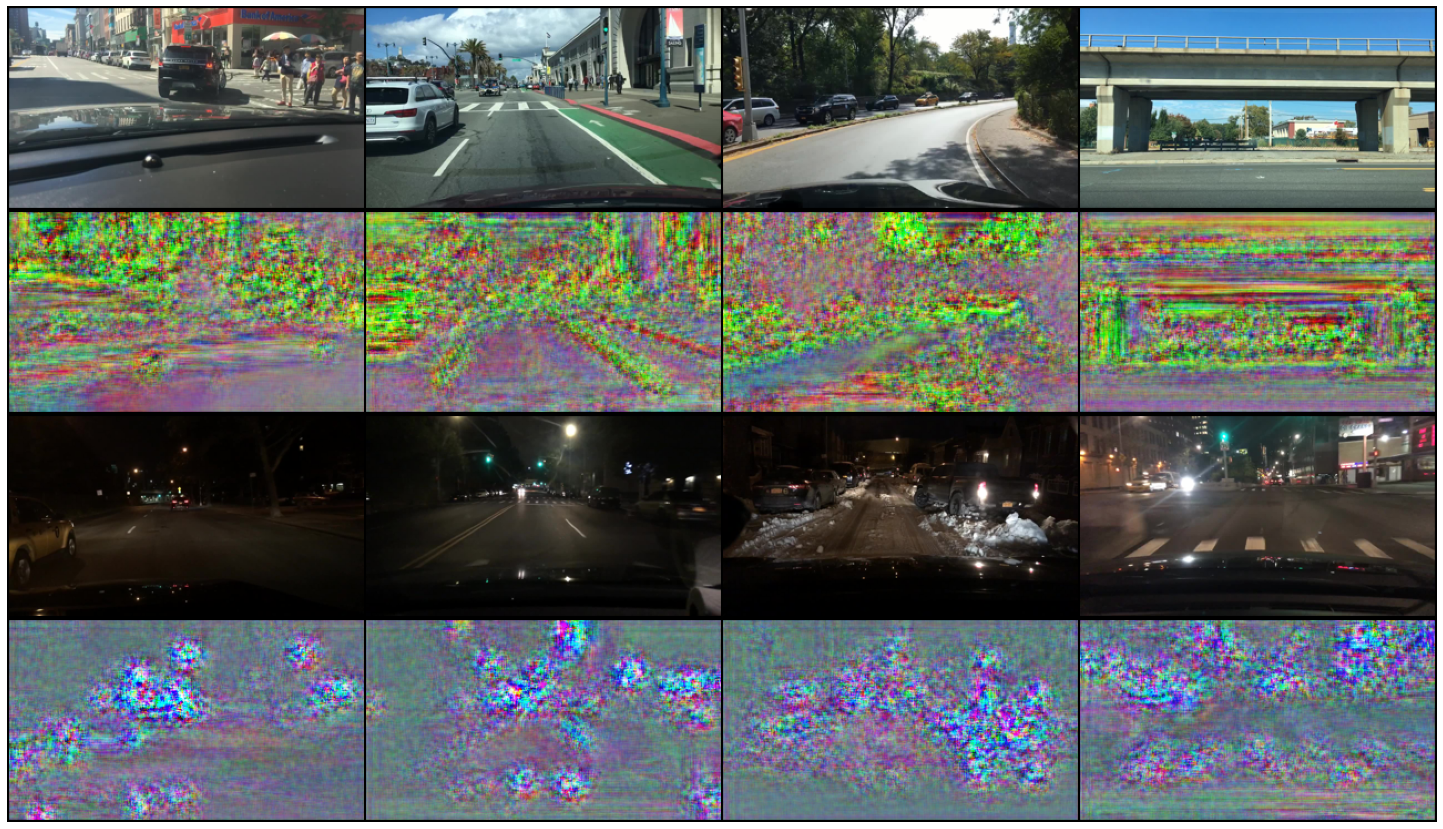

In [22]:
real_A, real_B = next(iter(train_loader))
print(real_A.shape)
print(real_B.shape)
sample_images(real_A, real_B)

# train

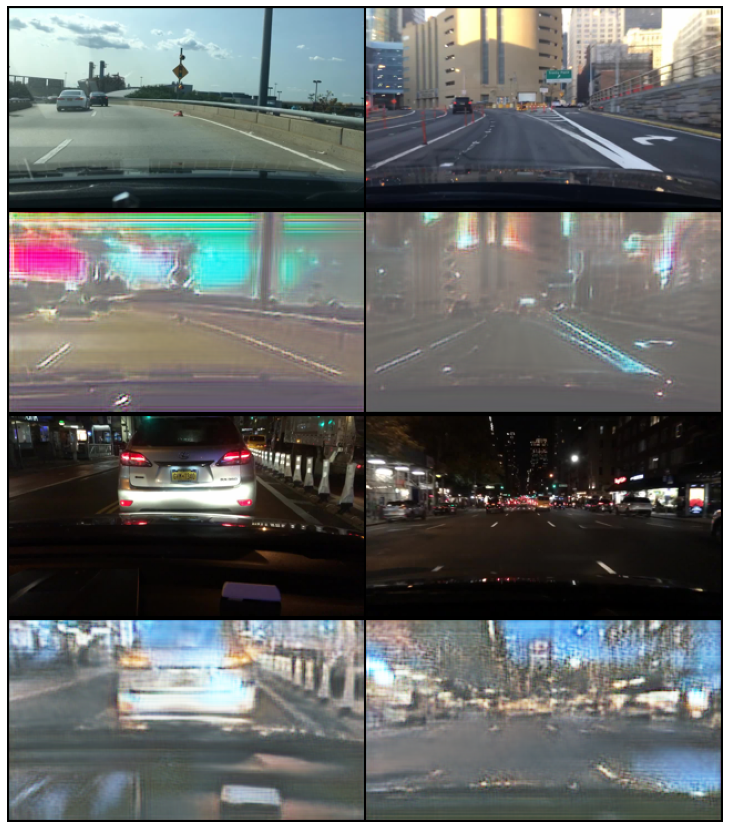

[Epoch 1/300]
[G loss: 2.0521178245544434 | identity: 0.23550790548324585 GAN: 0.3469994068145752 cycle: 0.05275789648294449]
[D loss: 0.3041948974132538 | D_A: 0.29118242859840393 D_B: 0.31720736622810364]


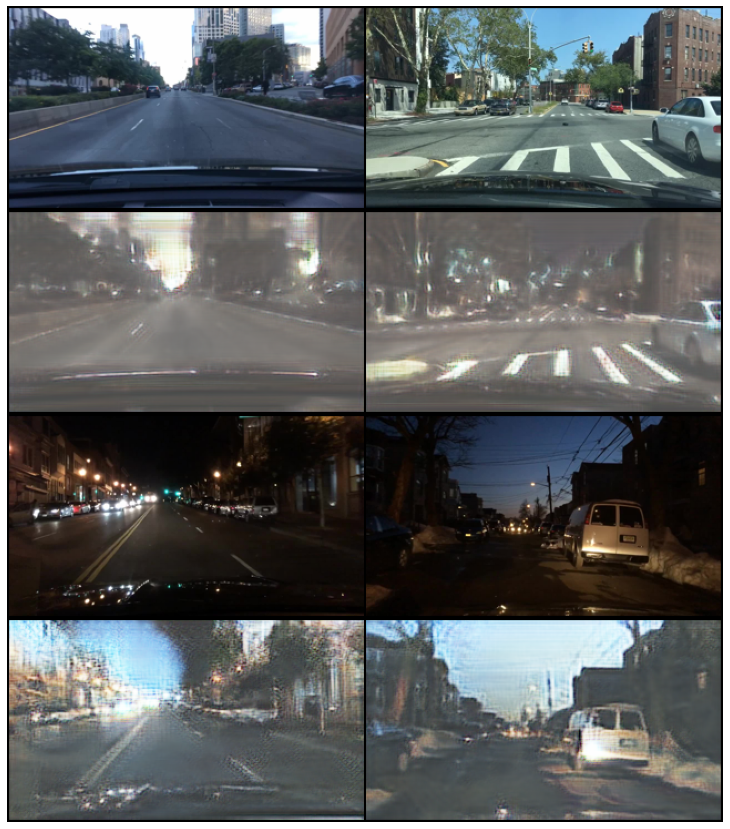

[Epoch 2/300]
[G loss: 1.9226746559143066 | identity: 0.19590267539024353 GAN: 0.5593748092651367 cycle: 0.03837864100933075]
[D loss: 0.1050453782081604 | D_A: 0.08655063062906265 D_B: 0.12354012578725815]


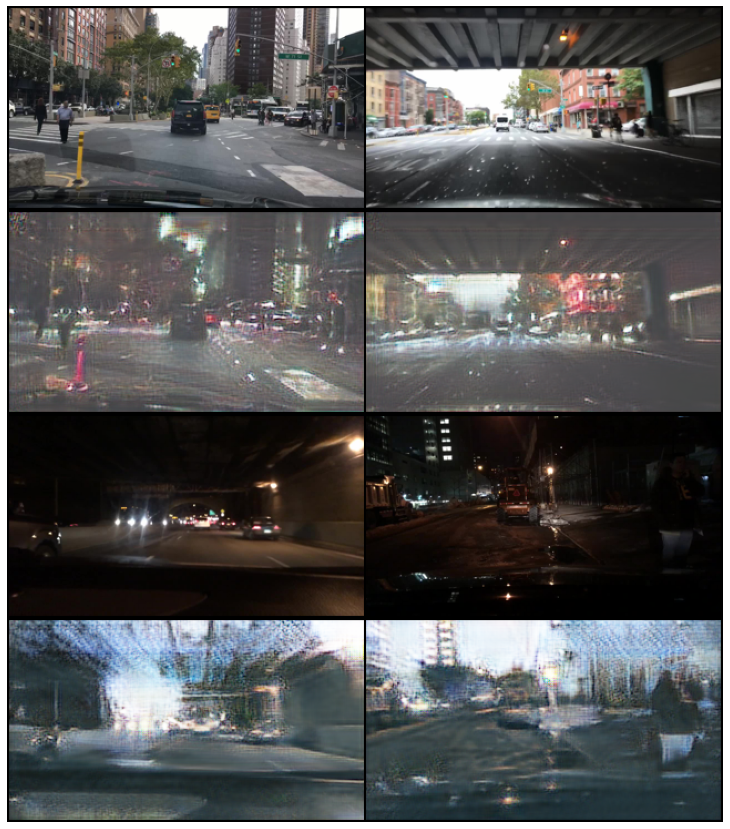

[Epoch 3/300]
[G loss: 2.202894926071167 | identity: 0.24605408310890198 GAN: 0.5795408487319946 cycle: 0.03930837661027908]
[D loss: 0.17484745383262634 | D_A: 0.2838873565196991 D_B: 0.06580756604671478]


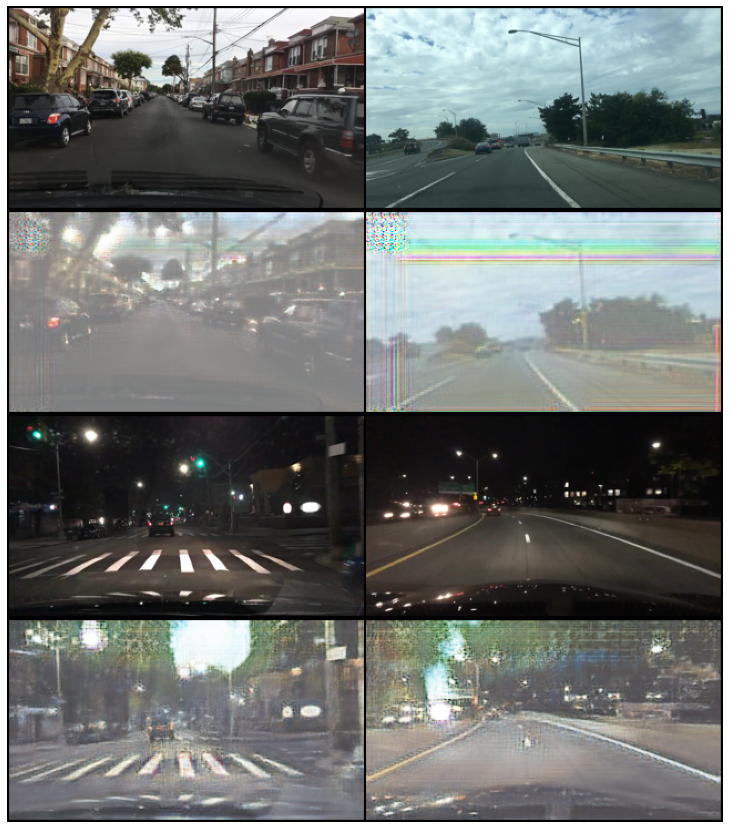

[Epoch 4/300]
[G loss: 1.821089744567871 | identity: 0.15495800971984863 GAN: 0.6700761914253235 cycle: 0.0376223549246788]
[D loss: 0.10977935045957565 | D_A: 0.14052672684192657 D_B: 0.07903197407722473]


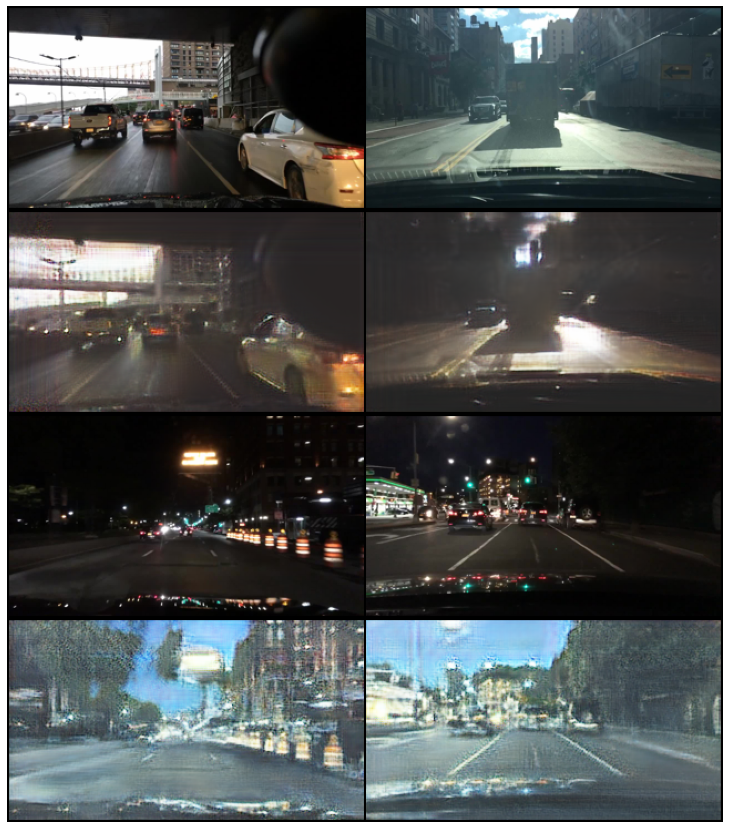

[Epoch 5/300]
[G loss: 1.8200575113296509 | identity: 0.19118954241275787 GAN: 0.4810061454772949 cycle: 0.038310375064611435]
[D loss: 0.16491471230983734 | D_A: 0.25480228662490845 D_B: 0.07502714544534683]


In [ ]:
from tqdm.notebook import tqdm

for epoch in range(n_epoches):
    for i, (real_A, real_B) in tqdm(enumerate(train_loader),total = len(train_loader)):
        real_A, real_B = real_A.type(Tensor), real_B.type(Tensor)
        
        # groud truth
        out_shape = [real_A.size(0), 1, real_A.size(2)//D_A.scale_factor, real_A.size(3)//D_A.scale_factor]
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)
        
        G_AB.train()
        G_BA.train()
        D_A.train()
        D_B.train()
        
        optimizer_G.zero_grad()
        
        fake_B = G_AB(real_A) 
        fake_A = G_BA(real_B)  
        
        loss_id_A = criterion_identity(fake_B, real_A) 
        loss_id_B = criterion_identity(fake_A, real_B)
        loss_identity = (loss_id_A + loss_id_B) / 2

        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) 
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)
        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
        
        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
        
        loss_G = 5.0*loss_identity + loss_GAN + 10.0*loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        optimizer_D_A.zero_grad()
        
        loss_real = criterion_GAN(D_A(real_A), valid)
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake)
        loss_D_A = (loss_real + loss_fake) / 2
        
        loss_D_A.backward()
        optimizer_D_A.step()
        
        optimizer_D_B.zero_grad()
        
        loss_real = criterion_GAN(D_B(real_B), valid)
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake)
        loss_D_B = (loss_real + loss_fake) / 2
        
        loss_D_B.backward()
        optimizer_D_B.step()
    
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    
 
    test_real_A, test_real_B = next(iter(test_loader))
    sample_images(test_real_A, test_real_B)

    loss_D = (loss_D_A + loss_D_B) / 2
    print(f'[Epoch {epoch+1}/{n_epoches}]')
    print(f'[G loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
    print(f'[D loss: {loss_D.item()} | D_A: {loss_D_A.item()} D_B: {loss_D_B.item()}]') 

In [ ]:
real_A, real_B = next(iter(test_loader))
print(real_A.shape)
print(real_B.shape)
sample_images(real_A, real_B)